In [41]:
import sys
import os
from scipy.optimize import curve_fit

# Get the project root (one level above notebooks/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

print("Added to Python path:", project_root)

import h5py
import numpy as np
import pandas as pd
# from src.parameters.tail_features import compute_LQ80


Added to Python path: c:\Users\YooNi\OneDrive\Desktop\Majorana-Neutrino-Hunt


In [42]:
train_file = "../data/old/MJD_Train_0.hdf5"

with h5py.File(train_file, "r") as f:
    waveforms = np.array(f["raw_waveform"])
    ids = np.array(f["id"])

print("Loaded", len(waveforms), "waveforms")

Loaded 65000 waveforms


In [43]:
def estimate_baseline(y, n_samples=200):
    """
    Returns baseline (mean, std) from the first n_samples.
    """
    y0 = np.asarray(y, dtype=float)[:n_samples]
    return float(np.mean(y0)), float(np.std(y0))


In [44]:
def compute_energy_duration(waveform, threshold=0.9, n_baseline=200):
    """
    Returns the number of samples needed to reach `threshold`
    fraction of total baseline-subtracted squared energy.
    """
    y = np.asarray(waveform, dtype=float)

    # subtract baseline (simple and robust)
    baseline = np.mean(y[:n_baseline])
    y = y - baseline

    # squared energy
    energy = y ** 2
    total_energy = float(np.sum(energy))
    if total_energy <= 0 or not np.isfinite(total_energy):
        return np.nan

    cumulative = np.cumsum(energy)
    target = threshold * total_energy

    idxs = np.where(cumulative >= target)[0]
    if len(idxs) == 0:
        return np.nan

    return int(idxs[0])


In [45]:
# compute Energy Duration for everything
ED_values = []

for i, wf in enumerate(waveforms):
    if i % 5000 == 0:
        print(f"Processing {i} / {len(waveforms)}")
    ED_values.append(compute_energy_duration(wf))

ED_values = np.array(ED_values, dtype=float)
ED_values[~np.isfinite(ED_values)] = np.nan

Processing 0 / 65000
Processing 5000 / 65000
Processing 10000 / 65000
Processing 15000 / 65000
Processing 20000 / 65000
Processing 25000 / 65000
Processing 30000 / 65000
Processing 35000 / 65000
Processing 40000 / 65000
Processing 45000 / 65000
Processing 50000 / 65000
Processing 55000 / 65000
Processing 60000 / 65000


In [46]:
# output
formatted_ids = [f"{id_}_train_0" for id_ in ids]

df = pd.DataFrame({
    "id": formatted_ids,
    "ED": ED_values
})


In [47]:

output_path = "ED_train_0.csv"
df.to_csv(output_path, index=False)
print("Saved to", output_path)
print(df.head())

Saved to ED_train_0.csv
          id      ED
0  0_train_0  3409.0
1  1_train_0  3404.0
2  2_train_0  3411.0
3  3_train_0  3408.0
4  4_train_0  3406.0


In [48]:
print(df["ED"].describe())
print("NaNs:", df["ED"].isna().sum())

count    65000.000000
mean      3405.992892
std          7.753049
min       3289.000000
25%       3404.000000
50%       3407.000000
75%       3410.000000
max       3756.000000
Name: ED, dtype: float64
NaNs: 0


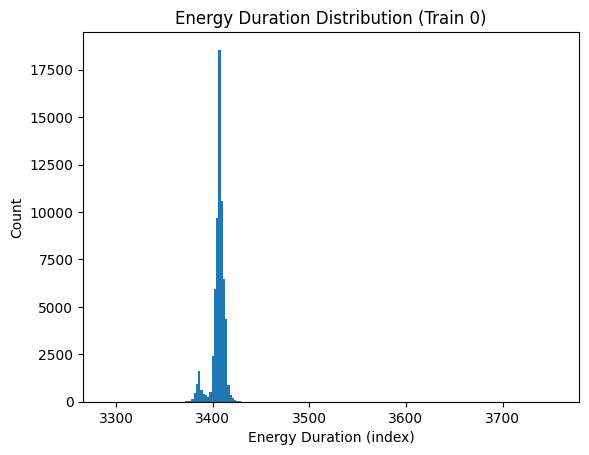

In [49]:
import matplotlib.pyplot as plt
import numpy as np

vals = df["ED"].to_numpy(dtype=float)
vals = vals[np.isfinite(vals)]

plt.figure()
plt.hist(vals, bins=200)
plt.xlabel("Energy Duration (index)")
plt.ylabel("Count")
plt.title("Energy Duration Distribution (Train 0)")
plt.show()
